In [1]:
import sys
from tqdm import tqdm
sys.path.append('./tvae')
from train import *

/home/andrewulmer/miniconda3/envs/mabe_2022/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load videos and stack mice to perform mean-centering and SVD

The TVAE accepts a sequence of frames as inputs. Before we split the videos into sequences, we are going to preprocess all the poses by normalizing the keypoint coordinates, mean-centering them, rotationally aligning the spine with the y-axis, and computing the singular value decomposition of the aligned pose. 

In [2]:
user_train = np.load('mouse_data/user_train.npy', allow_pickle=True).item()

In [3]:
# First we need to combine all the videos and normalize them to compute SVD
from datasets.mouse_v1.preprocess import normalize

full_dataset = []
for i, (name, sequence) in enumerate(tqdm(user_train['sequences'].items())):
    # Vectorizes each frame in the sequence
    vec_seq = sequence['keypoints'].reshape(sequence['keypoints'].shape[0], -1)
    full_dataset.append(normalize(vec_seq))
           
full_dataset = np.concatenate(full_dataset, axis=0)

100%|██████████| 1600/1600 [00:00<00:00, 1927.55it/s]


The output of the last step is an array of each of the frames stacked on top of one another. Each of the 3 mice has 12 keypoints, with both x and y coordinates. So `full_dataset` will be `total_frames x 72`. 

The next step is to rotationally align each of the mice's poses such that the vector formed by the keypoint at the neck base and the keypoint at the tail base is aligned with the y-axis. The angle of rotation is stored and fed as an input to the model. After the poses are rotationally aligned, the mean of each mouse's pose is subtracted, and the singular value decomposition of the normalized, aligned, and mean-centered pose is computed. In a sense, we are trying to limit the relevant sources of variance that the TVAE representations will capture.

In [4]:
# Next we need to complete the rotation alignment and compute SVD
from datasets.mouse_v1.preprocess import transform_to_svd_components
_, svd, mean = transform_to_svd_components(full_dataset)

# Create sub-sequences with sliding window and complete preprocessing

Next we iterate through each video and apply the preprocessing stack we developed in the last step. After each video is preprocessed, we pad the beginning and end of the video with repeat frames and create fixed-length sliding window sequences defined by `sub_seq_length` and `sliding_window` below. These sequences will be the inputs provided as inputs to the TVAE.

In [5]:
# Now we need to iterate through the videos, rotationally align, mean subtract, and apply SVD
preprocessed_data = []
sub_seq_length = 21
sliding_window = 5
for i, (name, sequence) in enumerate(tqdm(user_train['sequences'].items())):
    # Preprocess sequences
    vec_seq = sequence['keypoints'].reshape(sequence['keypoints'].shape[0], -1)
    vec_seq = normalize(vec_seq)
    
    if i == 0: # Here for debugging - leave to demonstrate that preprocessing works
        control = vec_seq
        control = control.reshape(control.shape[0], -1)
        control = np.pad(control, ((sub_seq_length//2, sub_seq_length-1-sub_seq_length//2), (0,0)), mode='edge')
        control = np.stack([control[i:len(control)+i-sub_seq_length+1:sliding_window] for i in range(sub_seq_length)], axis=1)
    
    vec_seq, _, _ = transform_to_svd_components(
            vec_seq,
            svd_computer=svd,
            mean=mean
    )
    
    # Pads the beginning and end of the sequence with duplicate frames
    vec_seq = vec_seq.reshape(vec_seq.shape[0], -1)
    pad_vec = np.pad(vec_seq, ((sub_seq_length//2, sub_seq_length-1-sub_seq_length//2), (0,0)), mode='edge')
    
    # Converts sequence into [number of sub-sequences, frames in sub-sequence, x/y alternating keypoints]
    sub_seqs = np.stack([pad_vec[i:len(pad_vec)+i-sub_seq_length+1:sliding_window] for i in range(sub_seq_length)], axis=1)
    preprocessed_data.append(sub_seqs)
        
preprocessed_data = np.concatenate(preprocessed_data, axis=0)

100%|██████████| 1600/1600 [01:19<00:00, 20.18it/s]


# Postprocessing demonstration

This next cell demonstrates how to postprocess the pose and also serves as a sanity check to make sure the unalignment, SVD, and unnormalization give us back approximately the same pose we started with.

<IPython.core.display.Javascript object>


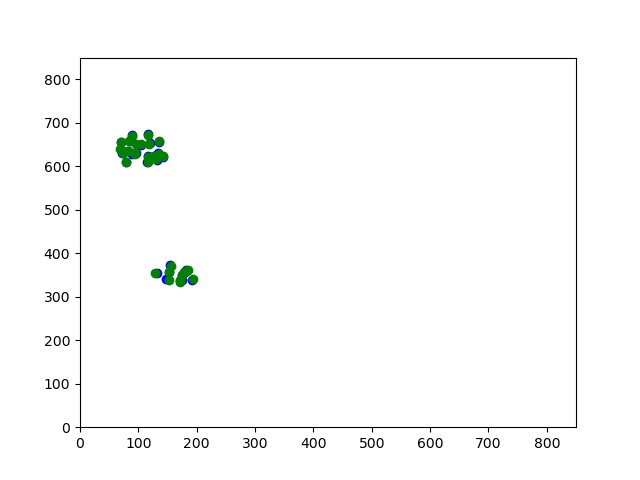

In [10]:
# Test postprocessing
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter

%matplotlib notebook

from datasets.mouse_v1.preprocess import transform_svd_to_keypoints
from datasets.mouse_v1.preprocess import unnormalize

random_seq = preprocessed_data[20] # Cannot compare postprocessed/original pairs outside of first sequence (index 1800)
random_seq = random_seq.reshape(-1, 3, 11)
random_seq = transform_svd_to_keypoints(random_seq, svd, mean)
random_seq = random_seq.reshape(random_seq.shape[0],-1)
random_seq = unnormalize(random_seq.reshape(random_seq.shape[0],-1))

control_seq = control[20] 
control_seq = control_seq.reshape(-1, 3, 12, 2)
control_seq = control_seq[:,:,:10,:]
control_seq = control_seq.reshape(control_seq.shape[0], -1)
control_seq = unnormalize(control_seq)

from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)
plt.xlim(0,850), plt.ylim(0,850)
for i in range(0,21):
    xvals = random_seq[i,::2]
    yvals = random_seq[i,1::2]
    plt.scatter(x=xvals, y=yvals, c='b')

    xvals = control_seq[i,::2]
    yvals = control_seq[i,1::2]
    plt.scatter(x=xvals, y=yvals, c='g')
    
    camera.snap()
    
animation = camera.animate()
writer = PillowWriter(fps=30)
animation.save('test.gif', writer=writer)

# Configure the model and training parameters

<!-- ![Screenshot%20from%202022-03-16%2016-02-04.png]() -->

<div>
<img src="tvae_diagram.png" width="750"/>
</div>

Above is the architecture that defines the trajectory variational autoencoder (TVAE) used here. The input to the model is comprised of states $s_{0}, ... , s_{\tau}$ and actions that define the change from one state to the next $a_{0}, ... , a_{\tau - 1}$. The encoder is a bi-directional GRU, the output of which, at each time step, is averaged and fed into fully-connected layers that produce a mean and variance which define a gaussian distribution (the posterior). A sample is then generated from the posterior and passed as an input, along with the initial state $s_{0}$ to the decoder. 

The decoder then "rolls out" each subsequent state by predicting a distribution of actions, and then sampling a single action used to act on the previous state i.e. $\hat{s_1} = s_{0} + \hat{a_{0}}, \hat{s_2} = \hat{s_1} + \hat{a_1}, \hat{s_3} = \hat{s_2} + \hat{a_2}$ etc. The output of each recurrent unit in the decoder is fed through fully-connected layers to produce the mean and variance of the gaussian distribution of actions. The reconstruction loss for a single trajectory is computed by taking the negative log-likelihood of the true action under the predicted distribution of actions and summing that across time. For more detail, the main computation of a forward pass through the model is completed in `./tvae/lib/models/core.py` in the method titled `forward`.


In this application, the input trajectory will be a sequence of preprocessed poses, and we will treat the mean of the posterior as our embedding. Below are adjustable model and dataset configurations and their associated descriptions.

In [ ]:
# Example model arguments
model_config = { 
    "name": "tvae",
    "z_dim": 32,      # Dimensionality of the posterior / embedding
    "h_dim": 256,     # Number of units to use in the fully-connected layers in the encoder and decoder
    "rnn_dim": 256,   # Number of units to use in the recurrent encoder and decoder
    "num_layers": 1,  # Number of layers to use in the recurrent encoder and decoder 
    "state_dim": 33,  # Dimensionality of the input states - we are only embedding single fly features for now
    "action_dim": 33  # Dimensionality of the input actions
}

# Example training arguments
train_config = { 
    "batch_size": 128,          # Batch size to use during training - higher = faster, but more GPU utilization
    "num_epochs_til_val": 10,   # Checkpoints will be saved to ./checkpoints/{project_name}/ every num_epochs_til_val epochs 
    "learning_rate": 0.0002,    # Learning rate for the optimizer to use
    "num_epochs": 300,          # Number of epochs to use
    "clip": 10,                 # Higher means potentially faster but more unstable training
    "project_name": 'test_mouse_jupyter_notebook'  # All checkpoints and loss logs will be saved to ./checkpoints/project_name/
}

# Split preprocessed data into training a validation sets

In [ ]:
# Split the dataset into a training and testing set
test_prop = 0.20
test_len = int(len(preprocessed_data) * test_prop)
np.random.shuffle(preprocessed_data)
data_train = preprocessed_data[test_len:]
data_test = preprocessed_data[:test_len]

# Create dataset object to train the TVAE using preprocessed data

In [ ]:
from datasets import load_dataset

# Device configurations
device = torch.device('cuda:0')

data_config = { 
    'name': 'mouse_v1',
    'data_train': data_train,
    'data_test': data_test,
    'device': device,
}   

# build dataset and train / val split
dataset = load_dataset(data_config)

data_loader = DataLoader(
                dataset,
                batch_size=train_config['batch_size'],
                shuffle = False
)

# Instantiate model and load most recent checkpoint if necessary

In [ ]:
# This will check and store the most recent checkpointed model in your project directory
from util.checkpoint_handler import checkpoint_handler
train_config = checkpoint_handler(train_config)

In [ ]:
# Define the model
model = TVAE(model_config)
model = model.to(device)
model.prepare_stage(train_config)

# Train the TVAE

In [ ]:
# Train the model
train_losses, val_losses = train(model, data_loader, train_config, device)

# Find best checkpoint

In [ ]:
with open(f'./checkpoints/{train_config["project_name"]}/val_losses.txt', 'r') as myFile:
    lines = myFile.readlines()
    klds, nlls = [],[]
    for i, line in enumerate(lines):
        if 'NLL' in line:
            nlls.append(float(line.split(' ')[-1]))
        elif 'KLD' in line:
            klds.append(float(line.split(' ')[-1]))

best_ckpt = np.array(nlls).argmin()*10

# Visualize some reconstructions of the validation set

In [ ]:
from reconstruct import *

model.load_state_dict(torch.load(f'./checkpoints/{train_config["project_name"]}/{best_ckpt}.pt'))

data_loader.dataset.eval()
model.eval()
recons, originals, embeddings = reconstruct(model, data_loader, data_config['device'])

In [ ]:
random_seq = recons[200] # Cannot compare postprocessed/original pairs outside of first sequence (index 1800)
random_seq = random_seq.reshape(-1, 3, 11)
random_seq = transform_svd_to_keypoints(random_seq, svd, mean)
random_seq = random_seq.reshape(random_seq.shape[0],-1)
random_seq = unnormalize(random_seq.reshape(random_seq.shape[0],-1))

original = originals[200]
original = original.reshape(-1,3,11)
original = transform_svd_to_keypoints(original, svd, mean)
original = original.reshape(original.shape[0], -1)
original = unnormalize(original.reshape(original.shape[0], -1))

from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)
plt.xlim(0,850), plt.ylim(0,850)
for i in range(0,21):
    xvals = original[i,::2]
    yvals = original[i,1::2]
    
    if i == 0: 
        plt.scatter(x=xvals, y=yvals, c='g', label = 'original')
    else:
        plt.scatter(x=xvals, y=yvals, c='g')

    xvals = random_seq[i,::2]
    yvals = random_seq[i,1::2]
    
    if i == 0:
        plt.scatter(x=xvals, y=yvals, c='b', label='reconstruction')
    else:
        plt.scatter(x=xvals, y=yvals, c='b')

    camera.snap()
    
plt.legend()
animation = camera.animate()
animation.save('test.gif', writer='imagemagick')

# Example submission
This just iterates through all the sequences provided in sample clips, preprocesses them, produces embeddings for them, and then saves them in the correct dictionary format.

In [ ]:
# Load best model checkpoint
model.load_state_dict(torch.load(f'./checkpoints/{train_config["project_name"]}/{best_ckpt}.pt'))

# Load submission clips - you may have to delete some of the larger arrays above in order to prevent the kernel from dying
submission_clips = np.load('mouse_data/submission_clips.npy',allow_pickle=True).item()
submission = {
    'frame_number_map': {},
    'embeddings': []
}

# Now we need to iterate through the videos, rotationally align, mean subtract, and apply SVD
sub_seq_length = 21
sliding_window = 1
start_idx = 0
for i, (name, sequence) in enumerate(tqdm(submission_clips['sequences'].items())):
    # Preprocess sequences
    vec_seq = sequence['keypoints'].reshape(sequence['keypoints'].shape[0], -1)
    vec_seq = normalize(vec_seq)
    
    vec_seq, _, _ = transform_to_svd_components(
            vec_seq,
            svd_computer=svd,
            mean=mean
    )
    
    # Pads the beginning and end of the sequence with duplicate frames
    vec_seq = vec_seq.reshape(vec_seq.shape[0], -1)
    pad_vec = np.pad(vec_seq, ((sub_seq_length//2, sub_seq_length-1-sub_seq_length//2), (0,0)), mode='edge')
    
    # Converts sequence into [number of sub-sequences, frames in sub-sequence, x/y alternating keypoints]
    data_test = np.stack([pad_vec[i:len(pad_vec)+i-sub_seq_length+1:sliding_window] for i in range(sub_seq_length)], axis=1)
    
    # Device configurations
    device = torch.device('cuda:0')

    data_config = { 
        'name': 'mouse_v1',
        'data_train': data_test,
        'data_test': data_test,
        'device': device,
    }   
   
    # build dataset and train / val split
    dataset = load_dataset(data_config)

    data_loader = DataLoader(
                    dataset,
                    batch_size=train_config['batch_size'],
                    shuffle = False
    )
    
    data_loader.dataset.eval()
    model.eval()
    _, _, embeddings = reconstruct(model, data_loader, data_config['device'])
    
    end_idx = start_idx + len(embeddings)
    submission['embeddings'].append(embeddings)
    submission['frame_number_map'][name] = (start_idx, end_idx)
    start_idx = end_idx
       
submission['embeddings'] = np.concatenate(submission['embeddings'], axis=0)
np.save('test_mouse_tvae_submission.npy', submission)    